# Introduction
We will create a class of support vector machine (SVM, support vector machine) for classification by scratch. We will implement the algorithm using only the minimum library such as NumPy.


There are soft margin SVMs that allow classification errors during learning and hard margin SVMs that do not, but here we will deal with hard margin SVMs that are simple to implement.



In [185]:
#predefines and imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample Code

In [186]:
class SampleSVM():
    def __init__(self, num_iter = 100, lr = 0.01, kernel = 'linear', gamma = 1, d = 1, theta = 0, threshold = 1e-5, verbose = False, debug = False):
        self.num_iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.d = d
        self.theta = theta
        self.threshold = threshold
        self.verbose = verbose 
        self.debug = debug

    def kernel_function(self,Xi,Xj):
        if self.kernel == 'poli':
            self.gamma = 1
            self.d = 2
            self.theta = 1
        return (self.gamma * np.dot(Xi,Xj.T) + self.theta)**self.d
    def update_lambda(self,X,y):
      #! sample code  
      for i in range(len(X)):
        total = 0
        for j in range(len(X)):
          total += self.lagrange_multiplier[j] * y[i] * y[j] * self.kernel_function(X[i], X[j])
        self.lagrange_multiplier[i] += self.lr * (1- total)

        if self.lagrange_multiplier[i] < 0:
          self.lagrange_multiplier[i] = 0
    def fit(self,X,y,X_val = None, y_val = None):
        self.labels = np.unique(y)
        y = np.where(y==self.labels[0],-1,1)
        
        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(y.shape[0]) 
        # self.lagrange_multiplier = np.ones(y.shape)

        if self.debug:
            print('Init Larg: ')
            print(self.lagrange_multiplier)
        for i in range(self.num_iter):
            self.update_lambda(X,y)
            if self.debug:
                print('Iter: ',i,'Lagrange : ')
                print(self.lagrange_multiplier)

        self.sv_index = self.lagrange_multiplier > self.threshold
        self.support_vectors_ = X[self.sv_index]
        self.n_support_vectors = self.support_vectors_.shape[0]
        self.sv_lagrange = self.lagrange_multiplier[self.sv_index]
        self.sv_label = y[self.sv_index]

        if self.verbose:
            print('n vec: ', self.n_support_vectors)
            
            result = pd.DataFrame(
                data = {
                    'SV: ': [str(x) for x in self.support_vectors_],
                    'Lagrange: ' : self.sv_lagrange.ravel(),
                    'Label: ': self.sv_label.ravel(),
                }, index = list(np.where(self.sv_index))
            )
            print(result)

    def predict(self,X):
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            total = 0
            for j in range(self.n_support_vectors):
                total += self.sv_lagrange[j] * self.sv_label[j]  * self.kernel_function(X[i],self.support_vectors_[j])

            if total > 0:
                y_pred[i] = self.labels[1]
            else:
                y_pred[i] = self.labels[0]
        return y_pred



# Prototype

In [187]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, degree = 2, verbose=False, debug = False, improved = False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.debug = debug
        self.improved = improved
        self.degree = degree
    def kernel_function(self,Xi,Xj):
      if self.kernel == 'linear':
        result = Xi @ Xj.T
      if self.kernel == 'simple_poli':
        result = (Xi @ Xj.T + 1)**self.degree

      # print('Kernel shape: ',result.shape)
      return result
    def fit(self, X, y, X_val=None, y_val=None):

        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(X.shape[0],1) #this can be dim 1 or 0
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1) if y_val else None
        self.labels = np.unique(y)

        if self.verbose:
          print('Xshape: ', X.shape, 'yshape: ', y.shape)
          if X_val:
            print('XValshape: ', X_val.shape, 'yvalshape: ', y_val.shape)

          print('Labels: ', self.labels)
        
        #Learn part
        if self.debug:
          print('Origin lagrange_multiplier: ')
          print(self.lagrange_multiplier.ravel())
        for i in range(self.iter):
          self.update_lagrange(X,y)
          if self.debug:
            print('Current Lar: ')
            print(self.lagrange_multiplier.ravel())
              
        
        #get sv part
        sv_index = []
        for idx, l in enumerate(self.lagrange_multiplier):
          if l > self.threshold: sv_index.append(idx)
        self.support_vectors_ = X[sv_index]
        self.n_support_vectors = len(sv_index)
        self.sv_lagrange = self.lagrange_multiplier[sv_index]
        self.sv_labels = y[sv_index]

        #validation part
        self.train_score = self.validate(X,y)
        self.valid_score = self.validate(X_val,y_val) if X_val else {'Score':'No validation set!'}


        # verbose part
        if self.verbose:
            result = pd.DataFrame({
              # 'SV Index': np.array(sv_index).reshape(-1,1),
              'support_vectors':[str(x) for x in self.support_vectors_],
              'label': self.sv_labels.ravel(),
              'L-multiple: ' : self.sv_lagrange.ravel()
            }, index = sv_index)
            print('Number of SVs: ', self.n_support_vectors)
            print(result)
            print('Training Score: ')
            print(pd.DataFrame(self.train_score, index = [0]))
            print('Validation Score: ')
            print(pd.DataFrame(self.valid_score, index = [0]))
            if self.debug: print('LagrangeMultiplier: ', self.lagrange_multiplier)
            
    def validate(self,X_val,y_val):
      pred = self.predict(X_val)
      acc = accuracy_score(pred,y_val)
      pre = precision_score(pred,y_val)
      rec = recall_score(pred,y_val)
      f1 = f1_score(pred,y_val)
      return {'Accuracy:': acc, 'Precision: ': pre, 'Recall: ':rec , 'F1-Score: ':f1}
      
    def update_lagrange(self,X,y):

      if self.improved:
        lm = self.lagrange_multiplier
        kernel_matrix = self.kernel_function(X,X) # precalculate, can put this outside the learning loop also!
        for i in range(lm.shape[0]):
          if lm[i] < 0:
            print('Lagrange multiple is less than zero: ', lm[i], ' index: ', i)
          temp = y * lm * kernel_matrix[i].reshape(-1,1)
          gradient_i = 1 - y[i]* temp.sum()
          lm[i] = max(0, lm[i] + self.lr * gradient_i)
        return



      lm = self.lagrange_multiplier
      for i in range(lm.shape[0]): #! update each lagrange multiple
        temp = 0
        #calc sum
        for j in range(lm.shape[0]):
          # if i == j: continue
          temp += y[i]* lm[j] * y[j] * self.kernel_function(X[i], X[j])
          # print(self.kernel_function(X[i],X[j]))
        #update
        lm[i] = max(0,lm[i] + self.lr * (1 - temp))

    def predict(self, X):
      if self.improved:
        #improved prediction code
        fx = self.kernel_function(X,self.support_vectors_) @ (self.sv_lagrange * self.sv_labels)
        get_label = np.vectorize(lambda x: self.labels[0] if x<0 else self.labels[1])
        return get_label(fx)
        
      #prep
      result = np.zeros((X.shape[0],1))
      #predict 
      for i in range(X.shape[0]):
        result[i] = self.predict_x(X[i])
      return result
    def predict_x(self,x):
      fx = 0
      for i in range(self.n_support_vectors):
        fx += self.sv_lagrange[i] * self.sv_labels[i] * self.kernel_function(x, self.support_vectors_[i])
      get_label = lambda x:  self.labels[0] if fx < 0 else self.labels[1]
      return get_label(fx)

# Graphing Code

In [188]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue']
    contourf_color =  ['pink', 'skyblue']
    n_class = 2

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    #!plot svs
    plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],color = 'yellow',s=80, label = 'SV')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# My Test

Xshape:  (4, 2) yshape:  (4, 1)
Labels:  [-1  1]
Number of SVs:  3
  support_vectors  label  L-multiple: 
0           [1 1]     -1    143.205821
1           [2 1]     -1      2.428571
3           [2 2]      1     73.531482
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0       0.75          1.0  0.666667         0.8
Validation Score: 
                Score
0  No validation set!
Prediction:  [ 1 -1  1  1]
----------------------
[LibSVM]SV: 
[[1. 1.]
 [2. 1.]
 [1. 2.]
 [2. 2.]]
Lambda: 
[[1. 1. 1. 1.]]
My model: 


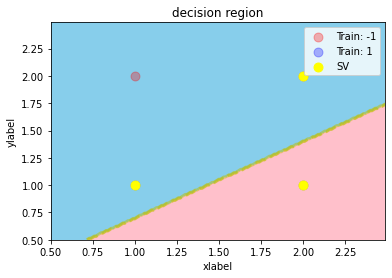

Sklearn: 


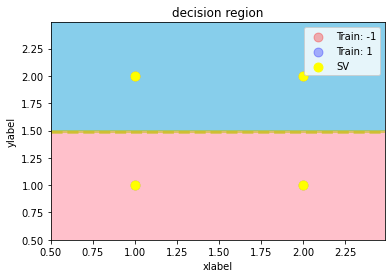

In [189]:
# ! simple test!

from sklearn.svm import SVC
ssvm = ScratchSVMClassifier(1000,0.1,verbose = True,debug = False, improved = True)
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])
ssvm.fit(x,y)
print('Prediction: ',ssvm.predict(x).ravel())


print('----------------------')
svc = SVC(kernel = 'linear', max_iter = 1000, verbose = True, tol = 1e-5)
svc.fit(x,y)
svc.predict(x)
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

print('My model: ')
decision_region(x,y,ssvm,target_names = ['-1', '1'])
print('Sklearn: ')
decision_region(x,y,svc, target_names = ['-1', '1'])

# Problem 1,2,3,4
Gradient, SV determination, Estimation, Validation

In [190]:
# Simple dataset:
np.random.seed(2658174532)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])


# test

print('My result: ')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))

#sk
svc = SVC(kernel = 'linear', max_iter = 100, verbose = True, tol = 1e-5)
print('Sklearn Result:')
svc.fit(x_train,y_train)
pred = svc.predict(x_test)
print(confusion_matrix(pred, y_test))
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

My result: 
Xshape:  (400, 2) yshape:  (400, 1)
Labels:  [-1  1]
Number of SVs:  6
               support_vectors  label  L-multiple: 
83   [ 1.00386276 -0.11148512]     -1      0.176754
147    [0.4605422  1.99913479]      1      0.012482
218  [-0.0021074   0.82847816]      1      0.398587
381    [1.0395929  2.50732824]      1      0.073211
387    [2.15396155 0.5955984 ]     -1      0.387722
398    [2.20169669 4.08608624]      1      0.085264
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        1.0          1.0       1.0         1.0
Validation Score: 
                Score
0  No validation set!
[[54  0]
 [ 0 46]]
Sklearn Result:
[LibSVM][[54  0]
 [ 0 46]]
SV: 
[[ 1.00386276 -0.11148512]
 [-0.0021074   0.82847816]]
Lambda: 
[[1. 1.]]


# Problem 5
Visualize Hyperplane

My model: 


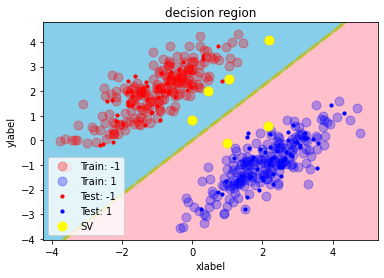

Sklearn: 


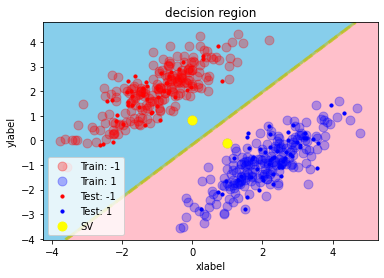

In [191]:
print('My model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)
print('Sklearn: ')
decision_region(x_train,y_train,svc, target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

# Problem 6
Polinomial Kernel

Circle data set

Text(0, 0.5, '$x_2$')

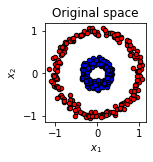

In [192]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=400, factor=.3, noise=.05)
plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [193]:
y[y==0] = -1
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))

Xshape:  (320, 2) yshape:  (320, 1)
Labels:  [-1  1]
Number of SVs:  320
               support_vectors  label  L-multiple: 
0    [ 0.6920464  -0.65233243]     -1      1.629831
1        [0.2752796 0.9573115]     -1      1.499277
2    [ 0.10471495 -1.0301502 ]     -1      1.570009
3    [ 0.24257339 -0.33134365]      1      1.313495
4    [ 0.23925282 -0.10404144]      1      1.367375
..                         ...    ...           ...
315  [ 0.24418329 -0.05229541]      1      1.032372
316    [0.21751847 0.22337469]      1      1.379076
317  [-0.03878365 -0.26339515]      1      1.915661
318    [0.26793427 0.04956886]      1      1.373009
319  [-0.65237557  0.80337977]     -1      1.218606

[320 rows x 3 columns]
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        0.5     0.509677  0.484663    0.496855
Validation Score: 
                Score
0  No validation set!
[[17 22]
 [18 23]]


My model: 


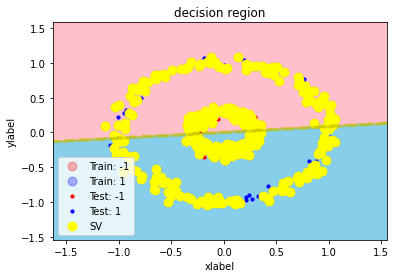

In [194]:
print('My model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

Xshape:  (320, 2) yshape:  (320, 1)
Labels:  [-1  1]
Number of SVs:  33
               support_vectors  label  L-multiple: 
3    [ 0.24257339 -0.33134365]      1      1.004241
20   [ 0.70769062 -0.62143549]     -1      0.151924
23     [0.3530203  0.10672335]      1      0.551326
28   [-0.87703721  0.24743816]     -1      0.912729
31   [ 0.33514636 -0.12391184]      1      0.032229
49   [ 0.30569568 -0.18251791]      1      0.242562
60   [-0.34142817  0.07135816]      1      0.058450
61   [-0.08989807 -0.35367704]      1      0.537617
62   [-0.36396003 -0.12107275]      1      0.945011
80   [-0.11445481 -0.32969475]      1      0.377474
88   [ 0.35785574 -0.01333177]      1      0.163957
105  [-0.00079129 -0.36120524]      1      0.640017
111  [-0.10100022  0.36517202]      1      0.102908
112  [-0.45631839 -0.71927443]     -1      1.151682
116    [0.0308831  0.92237194]     -1      0.186222
123  [-0.34870012  0.1053631 ]      1      0.487188
130  [ 0.01051148 -0.39522793]      1      1

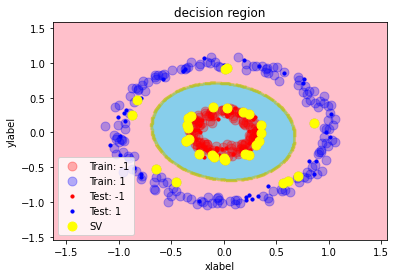

In [195]:
model = ScratchSVMClassifier(1000,0.01,verbose = True, improved= True, kernel = 'simple_poli')
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))
print('New model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

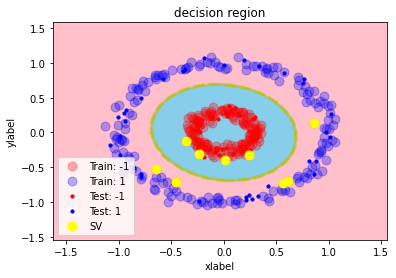

In [196]:
svc = SVC(kernel = 'poly', degree = 2)
svc.fit(x_train,y_train)
decision_region(x_train,y_train,svc,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

# ~~Final Note & Questions:~~ This has been updated
- As you can see from the 'My Test' section, my model behave weird in such simple situation, I do not understand why it does this, any suggestion would be nice
- Eventhough, other classification tasks have been performed well by the model
- Improvements have been made to hasten the training and predition time
- Polinomial kernel has also been added!
- Though achieved same result as sklean's preditions, the scratch model does not have same support vectors, any idea why?

# Update Section
Sample code from the lecture was added to the front of this note book for this section

## My model and Demo model comparision

In [197]:
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])

my_model = ScratchSVMClassifier(3,0.01, debug = True, improved = True, verbose = True)
sample_model = SampleSVM(num_iter=3, lr = 0.01, debug = True, verbose = True)

print('My model: ')
my_model.fit(x,y)

print('----------------------------')

print('Sample Model')
sample_model.fit(x,y)

My model: 
Xshape:  (4, 2) yshape:  (4, 1)
Labels:  [-1  1]
Origin lagrange_multiplier: 
[0.57051729 0.56452876 0.48844183 0.33647775]
Current Lar: 
[0.58028344 0.56862015 0.49398439 0.34724902]
Current Lar: 
[0.59032866 0.5730736  0.49908303 0.35752168]
Current Lar: 
[0.60060324 0.57781645 0.50380833 0.36738456]
Number of SVs:  4
  support_vectors  label  L-multiple: 
0           [1 1]     -1      0.600603
1           [2 1]     -1      0.577816
2           [1 2]      1      0.503808
3           [2 2]      1      0.367385
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0       0.75          1.0  0.666667         0.8
Validation Score: 
                Score
0  No validation set!
LagrangeMultiplier:  [[0.60060324]
 [0.57781645]
 [0.50380833]
 [0.36738456]]
----------------------------
Sample Model
Init Larg: 
[0.57051729 0.56452876 0.48844183 0.33647775]
Iter:  0 Lagrange : 
[0.58028344 0.56862015 0.49398439 0.34724902]
Iter:  1 Lagrange : 
[0.59032866 0.5730736  0.49908

Conclusion:
- After debuging the select support vector part, old/sample model are the same interms of calculation

## Special Case Test

n vec:  3
    SV:   Lagrange:   Label: 
0  [1 1]   12.081718       -1
1  [2 1]    2.432066       -1
3  [2 2]    7.915883        1
Prediction:  [ 1. -1.  1.  1.]
My model: 


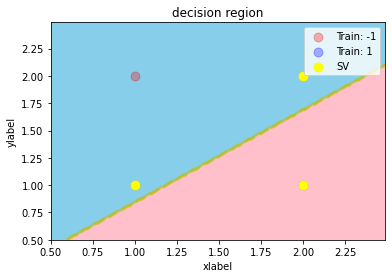

Xshape:  (4, 2) yshape:  (4, 1)
Labels:  [-1  1]
Number of SVs:  3
  support_vectors  label  L-multiple: 
0           [1 1]     -1     12.081718
1           [2 1]     -1      2.432066
3           [2 2]      1      7.915883
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0       0.75          1.0  0.666667         0.8
Validation Score: 
                Score
0  No validation set!


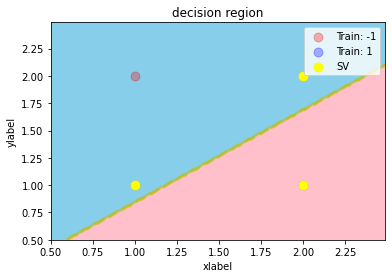

[LibSVM]

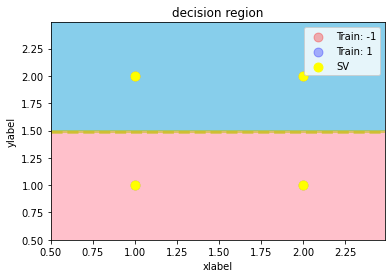

In [198]:

# ! simple test!
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])
ssvm = SampleSVM(num_iter = 1000,verbose = True,debug = False)
ssvm.fit(x,y)
print('Prediction: ',ssvm.predict(x).ravel())
print('My model: ')
decision_region(x,y,ssvm,target_names = ['-1', '1'])

old_model = ScratchSVMClassifier(1000,0.01,verbose = True, improved = True, debug = False)
old_model.fit(x,y)
decision_region(x,y,old_model,target_names = ['-1', '1'])

svc = SVC(kernel = 'linear', max_iter = 5, verbose = True, tol = 1e-5)
svc.fit(x,y)
decision_region(x,y,svc,target_names = ['-1', '1'])


Conclusion:
- Both my model still cant solve this special case, dont know why :(
- Must be something relating to gradient decent?

## Complex Test

----------Sk model: ----------
Sklearn Result:
[LibSVM][[43  0]
 [ 0 57]]
SVs:  [[ 0.67098941 -0.58384118]
 [-1.02829008  0.23898594]
 [-0.50179779  0.74466058]]


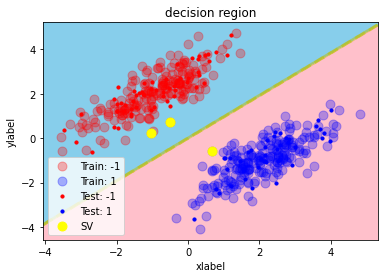

-----------Old model: ----------------
Xshape:  (400, 2) yshape:  (400, 1)
Labels:  [-1  1]
Number of SVs:  3
               support_vectors  label  L-multiple: 
21   [-1.02829008  0.23898594]      1      0.144381
62   [-0.50179779  0.74466058]      1      0.655346
226  [ 0.67098941 -0.58384118]     -1      0.472044
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        1.0          1.0       1.0         1.0
Validation Score: 
                Score
0  No validation set!


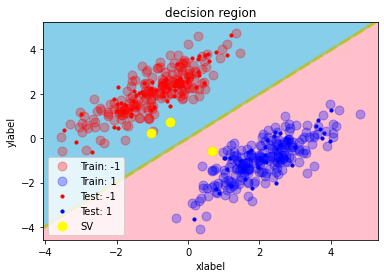

[[43  0]
 [ 0 57]]


In [199]:
# Simple dataset:
np.random.seed(0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])


# test

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)


print('----------Sk model: ----------')
svc = SVC(kernel = 'linear', max_iter = 1000, verbose = True, tol = 1e-5)
print('Sklearn Result:')
svc.fit(x_train,y_train)
pred = svc.predict(x_test)
print(confusion_matrix(pred, y_test))
print('SVs: ',svc.support_vectors_)
decision_region(x_train,y_train,svc,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)



print('-----------Old model: ----------------')
old_model = ScratchSVMClassifier(1000,0.01,verbose = True, improved = True)
old_model.fit(x_train,y_train)

decision_region(x_train,y_train,old_model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)
pred = old_model.predict(x_test)
print(confusion_matrix(pred,y_test))





Conclusion:
- My model has the same result as sklearn in this general case
- Same output and same support vectors

# Final Update
- Turns out, my old model was not logically wrong, it's just that i was graphing the support vectors on the validation set instead of the train set so the support vectors seems wrong
- I've updated the graphing to make it correct
- I've also add label checking to easily make prediction
- Though, the implementation (both mine and of sample code) cant handle the special case of square points!